In [1]:
from queue import PriorityQueue
from typing import List, Tuple, TypeVar, Dict

import numpy as np
from tilsdk.localization import *
import heapq

T = TypeVar('T')

def visualise_path(path, map):
    pathmap = map.grid.copy()
    pathmap = pathmap > 0
    pathmap = pathmap.astype("int32")
    gridpath = [map_.real_to_grid(x) if type(x) == RealLocation else x for x in path]
    gridpathx = [x[0] for x in gridpath]
    gridpathy = [x[1] for x in gridpath]
    plt.imshow(pathmap)
    plt.scatter(gridpathx,gridpathy,c='r')
    plt.title("visualise grid and path")
    plt.show()

def transform_add_border(og_grid):
    grid = og_grid.copy()
    a,b = grid.shape
    for i in range(a):
        for j in range(b):
            grid[i][j] = min(grid[i][j],i+1,a-i,j+1,b-j)
    return grid

def transform_for_astar(grid):
    #!-- Possible to edit this transform if u want
    grid2 = grid.copy()
    grid2[grid2>0] = 1 + 1000/(grid2[grid2>0])
    grid2[grid2<=0] = np.inf
    return grid2.astype("float32")

class NoPathFoundException(Exception):
    pass


class PriorityQueue:
    def __init__(self):
        self.elements: List[Tuple[float, T]] = []

    def is_empty(self) -> bool:
        return not self.elements

    def put(self, item: T, priority: float):
        heapq.heappush(self.elements, (priority, item))

    def get(self) -> T:
        return heapq.heappop(self.elements)[1]


class MyPlanner:
    def __init__(self, map_:SignedDistanceGrid=None, sdf_weight:float=0.0, waypoint_sparsity=0.5):
        '''
        Parameters
        ----------
        map : SignedDistanceGrid
            Distance grid map
        sdf_weight: float
            Relative weight of distance in cost function.
        waypoint_sparsity: float
            0.5 results in every 50th waypoint being taken at scale=0.01 and 10th at scale=0.05
        '''
        self.map = map_
        self.bgrid = transform_add_border(map_.grid.copy()) #Grid which takes the borders into account
        self.astar_grid = transform_for_astar(self.bgrid.copy())
        self.sdf_weight = sdf_weight
        self.waypoint_sparsity = waypoint_sparsity

    def update_map(self, map:SignedDistanceGrid):
        '''Update planner with new map.'''
        self.map = map

    def heuristic(self, a:GridLocation, b:GridLocation) -> float:
        '''Planning heuristic function.        
        Parameters
        ----------
        a: GridLocation
            Starting location.
        b: GridLocation
            Goal location.
        '''
        return euclidean_distance(a, b)
    
    def nearest_clear(self, loc, passable):
        '''Utility function to find the nearest clear cell to a blocked cell'''
        if not passable[loc]:
            best = (1e18,(-1,-1))
            for i in range(map_.height): #y
                for j in range(map_.width): #x
                    if map_.grid[(i,j)]>0:
                        best = min(best,(self.heuristic(GridLocation(i,j),loc),(i,j)))
            loc = best[1]
        return loc

    def plan(self, start:RealLocation, goal:RealLocation, method="astar") -> List[RealLocation]:
        '''Plan in real coordinates.
        
        Raises NoPathFileException path is not found.

        Parameters
        ----------
        start: RealLocation
            Starting location.
        goal: RealLocation
            Goal location.
        
        Returns
        -------
        path
            List of RealLocation from start to goal.
        '''

        path = self.plan_grid(self.map.real_to_grid(start), self.map.real_to_grid(goal), method=method)
        visualise_path(path, self.map)
        path = [self.map.grid_to_real(wp) for wp in path]
        
        return path

    def plan_grid(self, start:GridLocation, goal:GridLocation, method="astar") -> List[GridLocation]:
        '''Plan in grid coordinates.
        
        Raises NoPathFileException path is not found.

        Parameters
        ----------
        start: GridLocation
            Starting location.
        goal: GridLocation
            Goal location.
        method: string
            Either "astar" or "dijkstra"/"bfs" 
        
        Returns
        -------
        path
            List of GridLocation from start to goal.
        '''
        
        if not self.map:
            raise RuntimeError('Planner map is not initialized.')
        
        start = start[1],start[0]
        goal = goal[1],goal[0] #Use i=x,j=y convention for convenience
        passable = self.map.grid>0

        print("original start",start)
        print("original goal",goal)
        start = self.nearest_clear(start, passable)
        goal = self.nearest_clear(goal, passable)
        print("start",start)
        print("goal",goal)

        
        
        #astar
        if method == "astar":
            path = pyastar2d.astar_path(self.astar_grid, start, goal, allow_diagonal=False)
            coeff = int(self.waypoint_sparsity/self.map.scale) # default sparsity 0.5 --> 50 for 0.01, 10 for 0.05
            path = list(path)
            path = path[:1] + path[:-1:coeff]+ path[-1:] #Take the 1st, last, and every 20th waypoint in the middle
            path += path[:-1] #Duplicate last waypoint to avoid bug in main loop
            path = [(x[1],x[0]) for x in path]
            return path

        
        #Dijkstra's Algorithm/bfs (old method)----------------------------------------------------
        elif method == "dijkstra" or method == "bfs":
            pq = PriorityQueue() # ((Prev_waypoint,cur_moving_direction), priority)
            #Directions = 0 U, 1 R, 2 D, 3 L; -1 start (no irection); 4-7 diagonals
            dx = [0,1,0,-1,1,1,-1,-1]
            dy = [1,0,-1,0,1,-1,1,-1]
            dist = [10,10,10,10,14.142,14.142,14.142,14.142]

            pq.put(start, 0)

            prev_waypoint: Dict[tuple(int,int), tuple(int,int) ] = {}
            cost_so_far: Dict[tuple(int,int), float] = {}
            prev_waypoint[tuple(start)] = None
            cost_so_far[tuple(start)] = 0
            vis = np.zeros(map_.grid.shape)
            done = False
            #plt.imshow(passable)



            while not done and not pq.is_empty():
                location = pq.get()
                if vis[location]:
                    continue
                vis [location] = 1

                cost = cost_so_far[location]
                prev = prev_waypoint[location]

                for i in range(8):
                    cur = (location[0]+dx[i],location[1]+dy[i])
                    if (0<=cur[0]<self.map.height) and (0<=cur[1]<self.map.width) and (passable[cur]):
                        if (cur not in cost_so_far) or (cost + dist[i] < cost_so_far[cur]):
                            cost_so_far[cur] = cost + dist[i]
                            prev_waypoint[cur] = location
                            pq.put(cur, cost+dist[i])
                            done += (cur==goal)
            plt.imshow(vis)
            plt.title("Visited tiles in bfs")
            plt.show()
        #End Dijkstra/BFS-----------------------------------------------------------------
        
        
        
        if goal not in prev_waypoint:
            raise NoPathFoundException        
            
        return self.reconstruct_path(prev_waypoint, start, goal)

    def reconstruct_path(self,
                         came_from:Dict[GridLocation, GridLocation],
                         start:GridLocation, goal:GridLocation) -> List[GridLocation]:
        '''Traces traversed locations to reconstruct path.
        
        Parameters
        ----------
        came_from: dict
            Dictionary mapping location to location the planner came from.
        start: GridLocation
            Start location for path.
        goal: GridLocation
            Goal location for path.

        Returns
        -------
        path
            List of GridLocation from start to goal.
        '''
        current: GridLocation = goal
        path: List[GridLocation] = [goal]
        
        
        while current != start:
            path.append(current)
            current = came_from[current]
            
        # path.append(start)
        path.reverse()
        coeff = int(self.waypoint_sparsity/self.map.scale) # default sparsity 0.5 --> 50 for 0.01, 10 for 0.05
        path = path[:-1:coeff]+ path[-1:] #Take the 1st, last, and every 20th waypoint in the middle
        path = [(x[1],x[0]) for x in path]
        #print(path)
        
        return path

In [2]:
import logging
from typing import List

from tilsdk import *                                            # import the SDK
from tilsdk.utilities import PIDController, SimpleMovingAverage # import optional useful things
from tilsdk.mock_robomaster.robot import Robot                  # Use this for the simulator
# from robomaster.robot import Robot                             # Use this for real robot

# Import your code
from stubs.cv_service import CVService, MockCVService
from stubs.nlp_service import NLPService, MockNLPService
from stubs.planner import Planner
import pyastar2d

c:\users\qirui\appdata\local\programs\python\python38\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
# Setup logging in a nice readable format
logging.basicConfig(level=logging.INFO,
                format='[%(levelname)5s][%(asctime)s][%(name)s]: %(message)s',
                datefmt='%H:%M:%S')

# Define config variables in an easily accessible location
# You may consider using a config file
REACHED_THRESHOLD_M = 0.3   # TODO: Participant may tune.
ANGLE_THRESHOLD_DEG = 20.0  # TODO: Participant may tune.
ROBOT_RADIUS_M = 0.17       # TODO: Participant may tune.
NLP_MODEL_DIR = '../model.onnx'          # TODO: Participant to fill in.
NLP_PREPROCESSOR_DIR = '../finals_audio_model/'          # TODO: Participant to fill in.
CV_MODEL_DIR = ''           # TODO: Participant to fill in.

# Convenience function to update locations of interest.
def update_locations(old:List[RealLocation], new:List[RealLocation]) -> None:
    '''Update locations with no duplicates.'''
    if new:
        for loc in new:
            if loc not in old:
                logging.getLogger('update_locations').info('New location of interest: {}'.format(loc))
                old.append(loc)

In [4]:
# Initialize services
# cv_service = CVService(model_dir=CV_MODEL_DIR)

cv_service = MockCVService(model_dir=CV_MODEL_DIR)

#nlp_service = NLPService(model_dir=NLP_MODEL_DIR, preprocessor_dir=NLP_PREPROCESSOR_DIR)
nlp_service = MockNLPService(model_dir=NLP_MODEL_DIR)

loc_service = LocalizationService(host='localhost', port=5566)

#rep_service = ReportingService(host='localhost', port=5501)
# Start the run
#rep_service.start_run()

robot = Robot()
robot.initialize(conn_type="sta")
robot.camera.start_video_stream(display=False, resolution='720p')

In [5]:
# Initialize planner
map_:SignedDistanceGrid = loc_service.get_map()
map_ = map_.dilated(1.5*ROBOT_RADIUS_M/map_.scale)
planner = MyPlanner(map_, sdf_weight=0.5)

# Initialize variables
seen_clues = set()
curr_loi:RealLocation = None
path:List[RealLocation] = []
lois:List[RealLocation] = []
curr_wp:RealLocation = None

# Initialize tracker
# TODO: Participant to tune PID controller values.
tracker = PIDController(Kp=(1.0, 45.0), Kd=(0.0, 0.0), Ki=(0.0, 0.0)) #first: displacement, second: angle

# Initialize pose filter
pose_filter = SimpleMovingAverage(n=5)

# Define filter function to exclude clues seen before   
new_clues = lambda c: c.clue_id not in seen_clues

In [6]:
#Tune here
tracker = PIDController(Kp=(0.4, 0.5), Kd=(0.4, 0.5), Ki=(0.0, 0.0)) #first: displacement, second: angle

[ INFO][18:56:34][update_locations]: New location of interest: RealLocation(x=4.0, y=3.0)
[ INFO][18:56:34][Main]: Current LOI set to: RealLocation(x=4.0, y=3.0)
[ INFO][18:56:34][Main]: Planning path to: RealLocation(x=4.0, y=3.0)


original start (100, 105)
original goal (300, 400)
start (100, 105)
goal (300, 400)


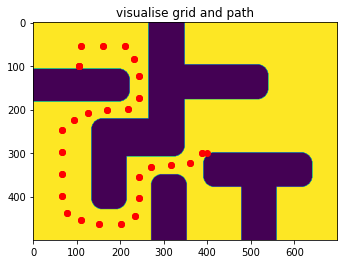

[ INFO][18:56:34][Main]: Path planned.
[ INFO][18:56:34][update_locations]: New location of interest: RealLocation(x=4.0, y=3.0)
[ INFO][18:56:34][Navigation]: New waypoint: RealLocation(x=1.05, y=1.0)
[ INFO][18:56:34][Navigation]: Pose: RealPose(x=1.0193860737401237, y=1.0070433262101925, z=-6.746511913619349)
[ INFO][18:56:34][Navigation]: Reached wp: RealLocation(x=1.05, y=1.0)
[ INFO][18:56:34][Navigation]: New waypoint: RealLocation(x=1.05, y=1.0)
[ INFO][18:56:34][Navigation]: Pose: RealPose(x=1.006895158907355, y=1.006415381262303, z=3.7192490589565756)
[ INFO][18:56:34][Navigation]: Reached wp: RealLocation(x=1.05, y=1.0)
[ INFO][18:56:34][Navigation]: New waypoint: RealLocation(x=1.1, y=0.55)
[ INFO][18:56:34][Navigation]: Pose: RealPose(x=1.009620579140842, y=0.9962374756129846, z=3.697206359283511)
[ INFO][18:56:34][Navigation]: dist: 0.45529806100650794 ang:82.2475957183923 vel:[ 0.18211922 41.12379786]
[ INFO][18:56:34][Navigation]: Pose: RealPose(x=1.0043645121807807, y=

[ INFO][18:56:36][Navigation]: Pose: RealPose(x=1.010897932614089, y=0.9915962857977764, z=-53.64709677436754)
[ INFO][18:56:36][Navigation]: dist: 0.4504957913708349 ang:24.945343306214696 vel:[ 0.18019832 12.47267165]
[ INFO][18:56:36][Navigation]: Pose: RealPose(x=0.9984428263042571, y=0.9739224557028123, z=-58.06683742116137)
[ INFO][18:56:36][Navigation]: dist: 0.43591754722443804 ang:18.460973509475835 vel:[0.17436702 9.23048675]
[ INFO][18:56:37][Navigation]: Pose: RealPose(x=0.9966234750224362, y=0.9567403949772857, z=-61.15717509809022)
[ INFO][18:56:37][Navigation]: dist: 0.41967184182729633 ang:14.582553331321577 vel:[0.16786874 7.29127667]
[ INFO][18:56:37][Navigation]: Pose: RealPose(x=1.0052565102825892, y=0.9542144213912099, z=-62.36962977156404)
[ INFO][18:56:37][Navigation]: dist: 0.4151693959150454 ang:14.438988974548316 vel:[0.16606776 7.21949449]
[ INFO][18:56:37][Navigation]: Pose: RealPose(x=1.0128099643717066, y=0.9632342804688416, z=-65.79363949263863)
[ INFO][1

[ INFO][18:56:39][Navigation]: dist: 0.5449919466207283 ang:-47.55392668508353 vel:[  0.21799678 -23.77696334]
[ INFO][18:56:39][Navigation]: Pose: RealPose(x=1.1200903033907388, y=0.790112623382433, z=-62.11089897730436)
[ INFO][18:56:39][Navigation]: dist: 0.5366259300548076 ang:-35.53078053685316 vel:[  0.21465037 -17.76539027]
[ INFO][18:56:39][Navigation]: Pose: RealPose(x=1.118711752073162, y=0.8060409250445808, z=-59.94696767787903)
[ INFO][18:56:39][Navigation]: dist: 0.5451562463094137 ang:-31.934400635301735 vel:[  0.2180625  -15.96720032]
[ INFO][18:56:39][Navigation]: Pose: RealPose(x=1.102201134570339, y=0.8220765902257259, z=-62.67056234251708)
[ INFO][18:56:39][Navigation]: dist: 0.5673000805322659 ang:-34.01134251572544 vel:[  0.22692003 -17.00567126]
[ INFO][18:56:39][Navigation]: Pose: RealPose(x=1.085888922435893, y=0.8181059526800701, z=-62.66713889320119)
[ INFO][18:56:39][Navigation]: dist: 0.5798198012629573 ang:-35.12535853496513 vel:[  0.23192792 -17.56267927]


[ INFO][18:56:41][Navigation]: dist: 0.39389023213882635 ang:-8.57942031261608 vel:[ 0.15755609 -4.28971016]
[ INFO][18:56:41][Navigation]: Pose: RealPose(x=1.2326418829934536, y=0.6924943482727806, z=-25.897533680683285)
[ INFO][18:56:41][Navigation]: dist: 0.39402617352186137 ang:-4.696784623791135 vel:[ 0.15761047 -2.34839231]
[ INFO][18:56:41][Navigation]: Pose: RealPose(x=1.2346145046511405, y=0.6859830449122619, z=-30.63749379527554)
[ INFO][18:56:41][Navigation]: dist: 0.3898691430659032 ang:-10.224077865338796 vel:[ 0.15594766 -5.11203893]
[ INFO][18:56:41][Navigation]: Pose: RealPose(x=1.2425275524798962, y=0.6924068969820595, z=-28.735055230416737)
[ INFO][18:56:41][Navigation]: dist: 0.3847938084793885 ang:-7.014118688885013 vel:[ 0.15391752 -3.50705934]
[ INFO][18:56:41][Navigation]: Pose: RealPose(x=1.2497534096727239, y=0.658114498736269, z=-25.475257931821556)
[ INFO][18:56:41][Navigation]: dist: 0.366553432493651 ang:-8.320790106823853 vel:[ 0.14662137 -4.16039505]
[ IN

[ INFO][18:56:43][Navigation]: dist: 0.7015481995633828 ang:-17.010133348139764 vel:[ 0.28061928 -8.50506667]
[ INFO][18:56:43][Navigation]: Pose: RealPose(x=1.402151746607411, y=0.5758210209033745, z=-22.964694947974703)
[ INFO][18:56:43][Navigation]: dist: 0.6983257906475886 ang:-20.84566560546419 vel:[  0.27933032 -10.4228328 ]
[ INFO][18:56:43][Navigation]: Pose: RealPose(x=1.4089034030494583, y=0.5550936004507275, z=-17.779637385216283)
[ INFO][18:56:43][Navigation]: dist: 0.691115367418618 ang:-17.35735701894278 vel:[ 0.27644615 -8.67867851]
[ INFO][18:56:43][Navigation]: Pose: RealPose(x=1.4296654575885013, y=0.5592312556279324, z=-21.04779695698169)
[ INFO][18:56:43][Navigation]: dist: 0.6703981017503717 ang:-20.258819927615075 vel:[  0.26815924 -10.12940996]
[ INFO][18:56:43][Navigation]: Pose: RealPose(x=1.4319858456736827, y=0.5633578681523458, z=-17.58360276810256)
[ INFO][18:56:43][Navigation]: dist: 0.6681476955149067 ang:-16.438046976771247 vel:[ 0.26725908 -8.21902349]


[ INFO][18:56:45][Navigation]: dist: 0.3742296612134392 ang:-4.210032189533923 vel:[ 0.14969186 -2.10501609]
[ INFO][18:56:45][Navigation]: Pose: RealPose(x=1.7513389438279405, y=0.49763790821965814, z=-0.3069201312947625)
[ INFO][18:56:45][Navigation]: dist: 0.3525710151822311 ang:-8.847799794862805 vel:[ 0.14102841 -4.4238999 ]
[ INFO][18:56:45][Navigation]: Pose: RealPose(x=1.7571345182478544, y=0.47066098800013495, z=-9.599953426751814)
[ INFO][18:56:45][Navigation]: dist: 0.3519253008839315 ang:-22.628868970827604 vel:[  0.14077012 -11.31443449]
[ INFO][18:56:45][Navigation]: Pose: RealPose(x=1.7666440540890294, y=0.47464218551289267, z=-4.2702119466686)
[ INFO][18:56:45][Navigation]: dist: 0.34176744560954214 ang:-17.008286221091808 vel:[ 0.13670698 -8.50414311]
[ INFO][18:56:45][Navigation]: Pose: RealPose(x=1.780481668766246, y=0.4702910631322561, z=-0.5621041510239735)
[ INFO][18:56:45][Navigation]: dist: 0.3293106111424122 ang:-14.569543909713017 vel:[ 0.13172424 -7.28477195]

[ INFO][18:56:47][Navigation]: dist: 0.5273792504739697 ang:-25.286353859421364 vel:[  0.2109517  -12.64317693]
[ INFO][18:56:47][Navigation]: Pose: RealPose(x=1.903416326752389, y=0.505574483838082, z=15.293343116412132)
[ INFO][18:56:47][Navigation]: dist: 0.5264510511070193 ang:-24.144831568598555 vel:[  0.21058042 -12.07241578]
[ INFO][18:56:47][Navigation]: Pose: RealPose(x=1.9272774308215488, y=0.5027037043058654, z=15.23646964049668)
[ INFO][18:56:47][Navigation]: dist: 0.5101424860247766 ang:-26.153501796050534 vel:[  0.20405699 -13.0767509 ]
[ INFO][18:56:47][Navigation]: Pose: RealPose(x=1.9242274194816678, y=0.476391337102545, z=16.468033869460733)
[ INFO][18:56:47][Navigation]: dist: 0.5301242718588238 ang:-26.837863351466552 vel:[  0.21204971 -13.41893168]
[ INFO][18:56:47][Navigation]: Pose: RealPose(x=1.9078781149404132, y=0.45769709403958375, z=18.638764912091737)
[ INFO][18:56:47][Navigation]: dist: 0.5548490987193315 ang:-24.913929575977626 vel:[  0.22193964 -12.45696

[ INFO][18:56:49][Navigation]: dist: 0.3417415098465231 ang:-4.993902385868964 vel:[ 0.1366966  -2.49695119]
[ INFO][18:56:49][Navigation]: Pose: RealPose(x=2.0583877951687186, y=0.6152607215600405, z=34.35367524492392)
[ INFO][18:56:49][Navigation]: dist: 0.3373669291643334 ang:-7.417459019698342 vel:[ 0.13494677 -3.70872951]
[ INFO][18:56:49][Navigation]: Pose: RealPose(x=2.0550773654016044, y=0.6058541043500568, z=37.9450106303479)
[ INFO][18:56:49][Navigation]: dist: 0.3461355949339814 ang:-4.6223975731883655 vel:[ 0.13845424 -2.31119879]
[ INFO][18:56:49][Navigation]: Pose: RealPose(x=2.0635193963441973, y=0.619695380677204, z=39.52344623868959)
[ INFO][18:56:49][Navigation]: dist: 0.3305855611993527 ang:-2.2669313763826366 vel:[ 0.13223422 -1.13346569]
[ INFO][18:56:49][Navigation]: Pose: RealPose(x=2.076189254030226, y=0.6230679596406524, z=31.422566482820166)
[ INFO][18:56:49][Navigation]: dist: 0.31894666492285473 ang:-11.432913447982592 vel:[ 0.12757867 -5.71645672]
[ INFO][1

KeyboardInterrupt: 

In [7]:
# Main loop
while True:
    # Get new data
    pose, clues = loc_service.get_pose()
    pose = pose_filter.update(pose)
    img = robot.camera.read_cv2_image(strategy='newest')
    if not pose:
        # no new data, continue to next iteration.
        continue

    # Filter out clues that were seen before
    clues = filter(new_clues, clues)

    # Process clues using NLP and determine any new locations of interest
    if clues:
        new_lois = nlp_service.locations_from_clues(clues) #new locations of interest
        update_locations(lois, new_lois)
        seen_clues.update([c.clue_id for c in clues])

    """    # Process image and detect targets
    targets = cv_service.targets_from_image(img)

    # Submit targets
    if targets:
        logging.getLogger('Main').info('{} targets detected.'.format(len(targets)))
        #logging.getLogger('Reporting').info(rep_service.report(pose, img, targets))
    """
    if not curr_loi:
        if len(lois) == 0:
            logging.getLogger('Main').info('No more locations of interest.')
            # TODO: You ran out of LOIs. You could perform and random search for new
            # clues or targets
            break
        else:
            # Get new LOI
            lois.sort(key=lambda l: euclidean_distance(l, pose), reverse=True)
            curr_loi = lois.pop()
            logging.getLogger('Main').info('Current LOI set to: {}'.format(curr_loi))

            # Plan a path to the new LOI
            logging.getLogger('Main').info('Planning path to: {}'.format(curr_loi))
            
            path = planner.plan(pose[:2], curr_loi)
            #path = [curr_loi,curr_loi]
            path.reverse() # reverse so closest wp is last so that pop() is cheap , waypoint
            curr_wp = None
            logging.getLogger('Main').info('Path planned.')
    else:
        # There is a current LOI objective.
        # Continue with navigation along current path.
        if path:
            # Get next waypoint
            if not curr_wp:
                curr_wp = path.pop()
                logging.getLogger('Navigation').info('New waypoint: {}'.format(curr_wp))

            #logging.getLogger('Navigation').info('Calculating angle')
            # Calculate distance and heading to waypoint
            dist_to_wp = euclidean_distance(pose, curr_wp)
            ang_to_wp = np.degrees(np.arctan2(curr_wp[1]-pose[1], curr_wp[0]-pose[0]))
            ang_diff = -(ang_to_wp - pose[2]) # body frame

            # ensure ang_diff is in [-180, 180]
            if ang_diff < -180:
                ang_diff += 360

            if ang_diff > 180:
                ang_diff -= 360

            #logging.getLogger('Navigation').info('ang_to_wp: {}, hdg: {}, ang_diff: {}'.format(ang_to_wp, pose[2], ang_diff))
            logging.getLogger('Navigation').info('Pose: {}'.format(pose))
            
            # Consider waypoint reached if within a threshold distance
            if dist_to_wp < REACHED_THRESHOLD_M:
                logging.getLogger('Navigation').info('Reached wp: {}'.format(curr_wp))
                tracker.reset()
                curr_wp = None
                continue

            # Determine velocity commands given distance and heading to waypoint
            vel_cmd = tracker.update((dist_to_wp, ang_diff))

            logging.getLogger('Navigation').info('dist: {} ang:{} vel:{}'.format(dist_to_wp,ang_diff,vel_cmd))
            
            # reduce x velocity
            vel_cmd[0] *= np.cos(np.radians(ang_diff))

            # If robot is facing the wrong direction, turn to face waypoint first before
            # moving forward.
            if abs(ang_diff) > ANGLE_THRESHOLD_DEG:
                vel_cmd[0] = 0.0

            # Send command to robot
            robot.chassis.drive_speed(x=vel_cmd[0], z=vel_cmd[1])

        else:
            logging.getLogger('Navigation').info('End of path.')
            curr_loi = None

            # TODO: Perform search behaviour? Participant to complete.

            continue

robot.chassis.drive_speed(x=0.0, y=0.0, z=0.0)  # set stop for safety
logging.getLogger('Main').info('Mission Terminated.')

# Below: Random working

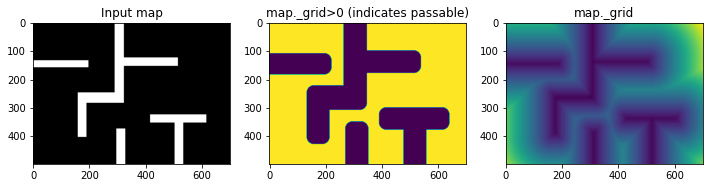

In [8]:
fig, ax = plt.subplots(1,3,figsize=(12,30))
ax[0].imshow(plt.imread("data/maps/map_complex_1cm.png"))
ax[0].title.set_text("Input map")
ax[1].imshow(map_.grid>0)
ax[1].title.set_text("map._grid>0 (indicates passable)")
ax[2].imshow(map_.grid)
ax[2].title.set_text("map._grid")

In [9]:
curr_loi

RealLocation(x=4.0, y=3.0)

## Test planner manually

In [10]:
myplanner = MyPlanner(map_, sdf_weight=0.5,waypoint_sparsity = 0.5)
curr_loi = RealLocation(x=4.0, y=3.0)
pose = RealPose(x=1.0, y=1.0, z=0.0)

original start (100, 100)
original goal (300, 400)
start (100, 100)
goal (300, 400)


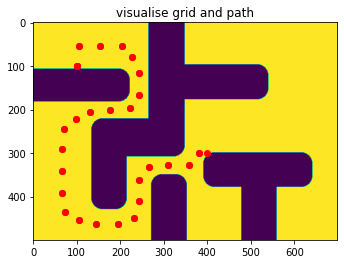

0.20342731475830078


In [11]:
import time
start = time.time()
path = None #Needed or path will be taken as a local variable in try
try:
    path = myplanner.plan(pose[:2], curr_loi, method="astar")
except Exception as e:
    print("Error",e)
end = time.time()
print(end - start)

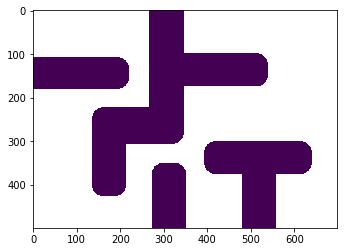

In [12]:
map = planner.map.grid.astype(np.float32)
map[map>0] = np.inf
map[map<=0] = 1
path_astar = pyastar2d.astar_path(map, tuple(real_to_grid(RealLocation(1, 1), scale=planner.map.scale)), tuple(real_to_grid(RealLocation(4, 3), scale=planner.map.scale)), allow_diagonal=True)
plt.imshow(map)
# path_astar.reverse()
# path_astar = path_astar[:1] + path_astar[1:-1:20]+ path_astar[-1:] #Take the 1st, last, and every 20th waypoint in the middle
# path_astar = [(x[1],x[0]) for x in path_astar]

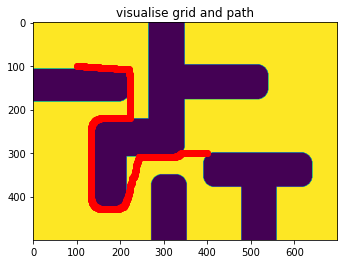

In [13]:
import pyastar2d
map = planner.map.grid.astype(np.float32)
map[map>0] = 1
map[map<=0] = 1e18
path = pyastar2d.astar_path(map, tuple(real_to_grid(RealLocation(1, 1), scale=planner.map.scale)), tuple(real_to_grid(RealLocation(3, 4), scale=planner.map.scale)), allow_diagonal=False)
path = [(x[1],x[0]) for x in path]
visualise_path(path,planner.map)

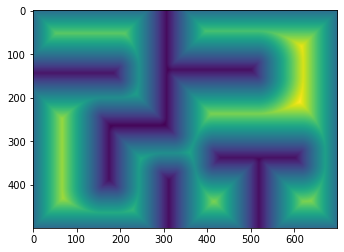

In [14]:
trf_grid = transform_add_border(map_.grid).astype("float32")
plt.imshow(trf_grid)

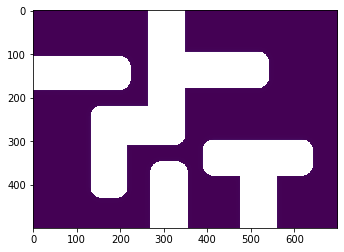

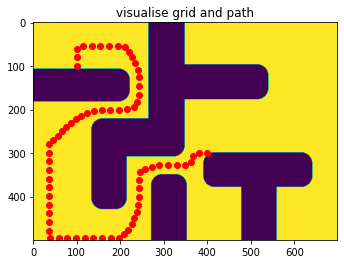

In [15]:
trf_grid = transform_add_border(map_.grid).astype("float32")
trf_grid = transform_for_astar(map_.grid).astype("float32")
plt.imshow(trf_grid)
plt.show()
path = pyastar2d.astar_path(trf_grid, tuple(real_to_grid(RealLocation(1, 1), scale=planner.map.scale)), tuple(real_to_grid(RealLocation(3, 4), scale=planner.map.scale)), allow_diagonal=False)
path = [(x[1],x[0]) for x in path]
visualise_path(path[:-1:20]+path[-1:],planner.map)